# Insights into Galaxy Populations and Evolution through mock catalgoues from Euclid.


In this work, we explore galaxy properties using a mock catalogue generated for the Euclid mission. A mock catalogue is built from real observational data combined with N-body simulations that reproduce the large-scale dark matter structure and its evolution in the universe.

Our goal is to analyze this dataset and extract insights into the distribution and characteristics of galaxies within these simulated cosmological environments.

In [4]:
# @title Libraries and project globals
!pip install -healpy
!pip install gdown
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as si
import os
import healpy as hp
plt.rcParams['text.usetex'] = False  
plt.rcParams['mathtext.fontset'] = 'cm' 
plt.rcParams['font.family'] = 'serif'


blue1 = "#0582ca"
blue2 = "#006494"
blue3 = "#003554"

H0=100

In [14]:
# Get the folder where this script is located
url='https://drive.google.com/uc?id=1i2tbMEB7a5w2EHjCEGq_9p1D13t2P-f8'
output = "cosmological_data.csv"
gdown.download(url, output, quiet=False)
data=pd.read_csv(output,compression='bz2',header=10)
#header means the number of rows that contain "useless" data (titles, etc), real data starts at row 11
#Print a sample of the data
print("Data sample:\n")
print(data)


Downloading...
From (original): https://drive.google.com/uc?id=1i2tbMEB7a5w2EHjCEGq_9p1D13t2P-f8
From (redirected): https://drive.google.com/uc?id=1i2tbMEB7a5w2EHjCEGq_9p1D13t2P-f8&confirm=t&uuid=3815dc7b-fe57-4f5b-b0e4-f430726f553a
To: C:\Users\celja\pyton\cosmological_data.csv
100%|███████████████████████████████████████████████████████████████████████████████| 214M/214M [00:37<00:00, 5.72MB/s]


Data sample:

            ra_gal    dec_gal   z_cgal     cgal  z_cgal_v   mr_gal  gr_gal  \
0        52.355554  16.748874  0.60021  1577.50   0.60035 -17.4768  0.4294   
1        50.020451  59.551353  0.35581   990.16   0.35554 -17.0846  0.6914   
2        75.955679  38.476419  0.48858  1318.56   0.48957 -16.6204  0.3067   
3        79.576830  58.184861  0.67847  1749.92   0.67862 -16.8399  0.4313   
4        10.578740  62.817999  0.58545  1544.13   0.58406 -19.9465  0.9056   
...            ...        ...      ...      ...       ...      ...     ...   
7804720  89.717611  64.251853  0.69005  1774.82   0.68822 -17.2442  0.2594   
7804721  55.886664  12.416796  0.69782  1791.45   0.69733 -17.8527  0.3030   
7804722  19.954148  19.552936  0.76033  1922.58   0.75644 -19.0695  0.7479   
7804723  26.675875  20.159539  0.55643  1477.79   0.55817 -20.4858  0.9225   
7804724  41.312334  53.711818  0.86510  2132.50   0.86635 -20.1297  0.9290   

         des_asahi_full_r_abs_mag  des_asahi_full

- ra_gal: galaxy right ascension (degrees)
- dec_gal: galaxy declination (degrees)
- z_cgal: galaxy true redshift
- cgal: galaxy comoving distance (Mpc/h)
- z_cgal_v: galaxy observed redshift (including peculiar velocity)
- mr_gal: absolute magnitude without evolution (Mr-5log(h)) in the r-band filter redshifted to z=0.1
- gr_gal: (g-r) rest-frame at z=0 without evolutionary correction
- des_asahi_full_r_abs_mag: absolute magnitude in des asahi full g-band
- des_asahi_full_r_true: observed magnitude in des asahi full g-band
  

### Galaxy Survey plot

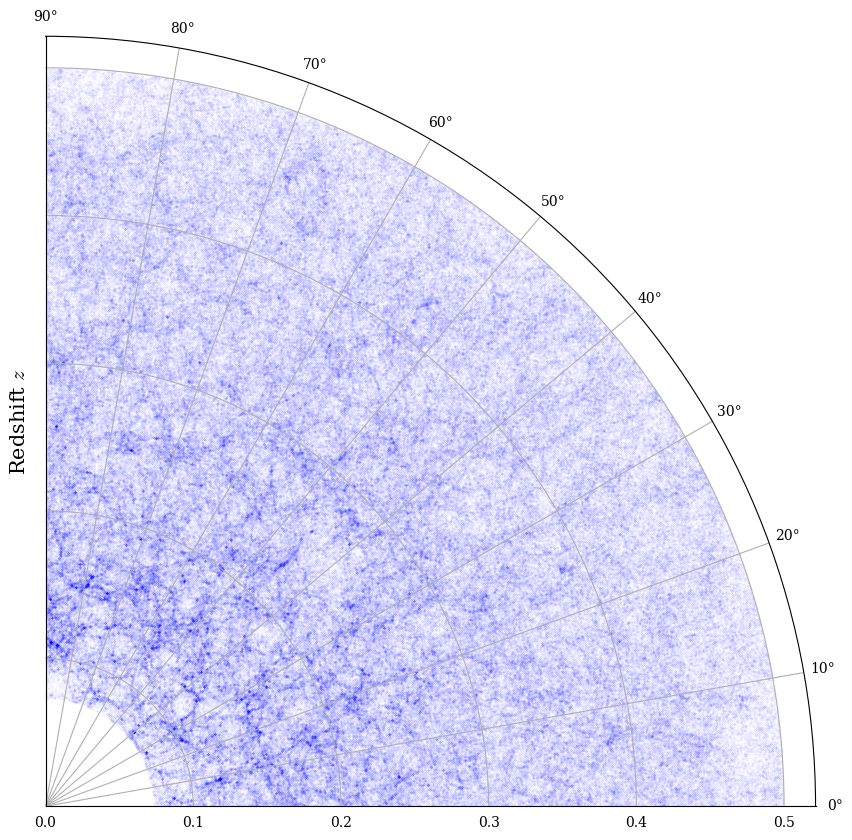

In [3]:
#set polar plot
plt.rcParams['figure.figsize']=[10,10]
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
d_min = 0 # @param
d_max = 20 # @param

z_min = 0 # @param
z_max = 0.5 # @param
mask = (d_min < data['dec_gal']) & (d_max > data['dec_gal'])

theta = np.radians(data['ra_gal'][mask])
r = data['z_cgal'][mask]

mask2 = (z_min < data["z_cgal"]) & (z_max > data["z_cgal"])
#plot
ax.scatter(theta[mask2], r[mask2], s=0.05, alpha=0.07, c='blue')
ax.set_thetamin(0)
ax.set_thetamax(90)
plt.ylabel(r'Redshift $z$',size=15)
plt.show()

### Healpix plot


Healpix allow us to show visually the evolution of structure.

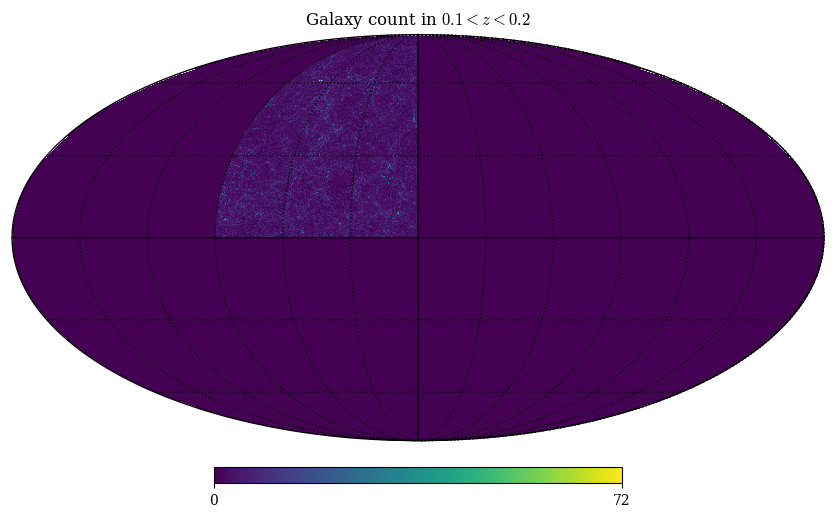

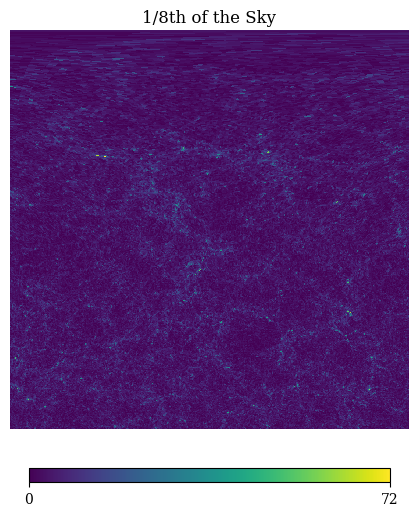

In [ ]:

#resolution
nside = 64 * 4
npix = hp.nside2npix(nside)

zmin = 0.1
zmax = 0.2

mask = (zmin < data['z_cgal']) & (zmax > data['z_cgal'])
theta = np.radians(90 - data['dec_gal'][mask])
phi = np.radians(data['ra_gal'][mask])

#get pixel indices
pix = hp.ang2pix(nside, theta, phi)

#create an empty array map
gal_map = np.zeros(npix)
for p in pix:
  gal_map[p] += 1

#Full map
hp.mollview(gal_map,cmap='viridis',title=r'Galaxy count in $0.1<z<0.2$')
hp.graticule()

hp.cartview(
    gal_map,
    lonra=[0, 90],   # RA range
    latra=[0, 90],  # Dec range
    title='1/8th of the Sky',
    cmap='viridis'
)

### Galaxy luminosity function

Our goal is to compute the galaxy luminosity function and compare it with the widely used Schechter luminosity function. To calculate the luminosity density, we first determine the comoving volume, which requires computing the comoving distances of galaxies.

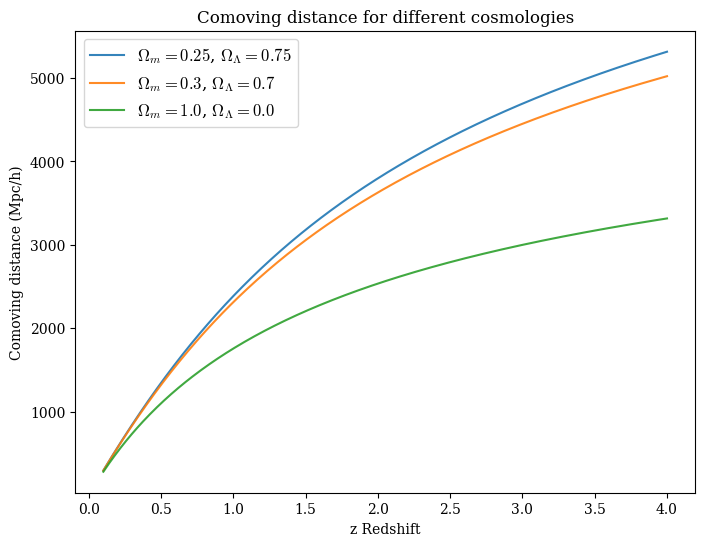

In [5]:
n = 400
z = np.linspace(0.1, 4, n)

param_sets = [
    {"label": r"$\Omega_m=0.25$, $\Omega_\Lambda=0.75$", "omega_m": 0.25, "omega_lam": 0.75},
    {"label": r"$\Omega_m=0.3$, $\Omega_\Lambda=0.7$", "omega_m": 0.3, "omega_lam": 0.7},
    {"label": r"$\Omega_m=1.0$, $\Omega_\Lambda=0.0$", "omega_m": 1.0, "omega_lam": 0.0},
]

fig, ax = plt.subplots(figsize=(8, 6))

# Every set of parameters
for params in param_sets:
    omega_m = params["omega_m"]
    omega_lam = params["omega_lam"]

    # H(z) 
    def H(z):
        return np.sqrt(omega_m * ((1 + z)**3) + omega_lam)
    com_dist = np.zeros(n)
    com_dist_a = np.zeros(n)
    for i in range(n):
        com_dist[i] = (c / H0) * si.quad(lambda z_: 1 / H(z_), 0, z[i])[0]
    com_dist_a = (c / H0) * (z / H(z / 2))
    ax.plot(z, com_dist, label=params["label"], alpha=0.9)


ax.set_xlabel('z Redshift')
ax.set_ylabel('Comoving distance (Mpc/h)')
ax.legend(fontsize=12)

plt.title("Comoving distance for different cosmologies")
plt.show()

#### Volume calculation 

In [6]:
c_galmin=np.min(data["cgal"]) # smallest comoving distance
c_galmax=np.max(data["cgal"]) # greater comoving distance

h = 1
Vo= 4 / 3 * (np.pi)*((c_galmax)**3-(c_galmin)**3)*h**3 * (1/8) #just 1 / 8 of the universe is in data
V=Vo/(1000)**3 # Gpc
print("Volume =", V)

Volume = 15.015468558610262


In theory, the volume $V$ (in comoving coordinates) is just the spherical shell containing
all the measured galaxies. That is,

$V = \frac{1}{4}\frac{4\pi}{3} (R_{max}^3-R_{min}^3)$

The factor $\frac14$ appears beacause we are only measuring one forth of the sky.

#### Histogram of $M_r-5\log(h)$

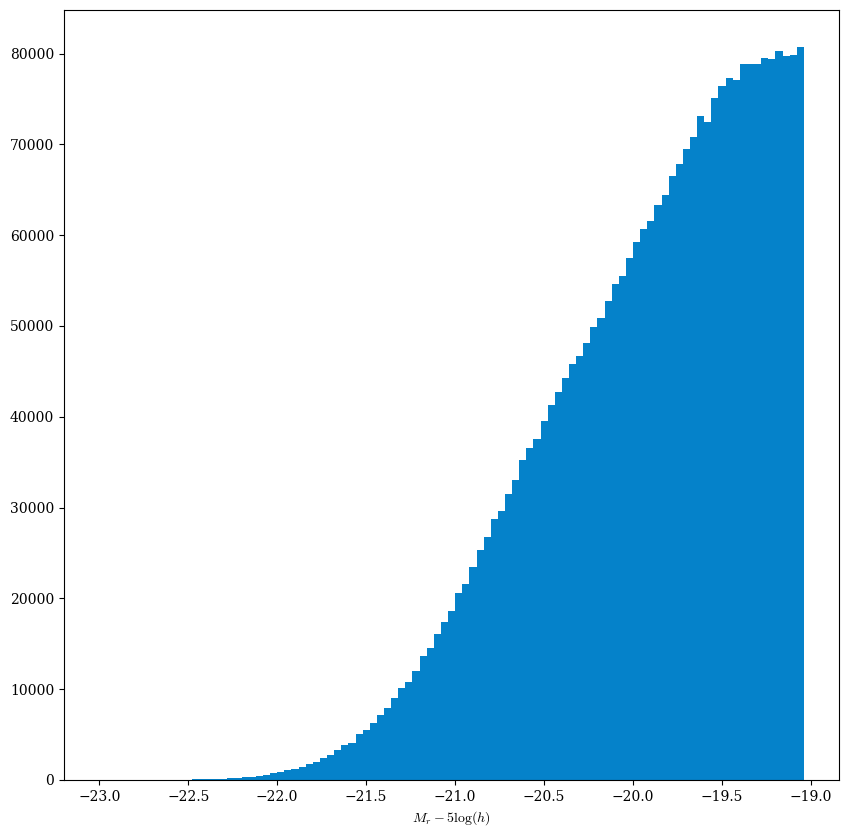

In [10]:
nbins = 100
max = -19
min = -23
N = (max - min) / nbins

n_bins=np.arange(min, max, N)
count, bin, patch = plt.hist(data["mr_gal"],bins = n_bins, color=blue1)

plt.xlabel(r'$M_r-5\log(h)$')

plt.show()


The histogram show us the population of galaxies across diferent magnitudes. 

With the densisty computed we plot vs Schechter luminosity function.

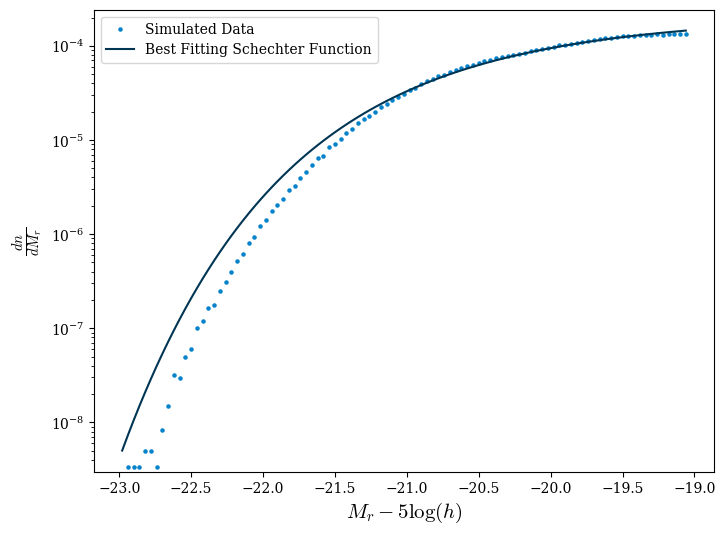

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Given parameters
phi =0.00019620985143358014# Normalization
#phi = 1.49*10**(-2)
alpha = -1.05  # Slope
M = -20.44  # Characteristic magnitude

# Schechter function
def Schechter(x, phi, alpha, M):
    a = 0.4 * (x - M)
    return (0.4 * np.log(10)) * phi * 10**(-a * (alpha + 1)) * np.exp(-10**(-a))

# Histogram settings
nbins = 100
M_min, M_max = -23, -19  # Magnitude range
N = (M_max - M_min) / nbins  # Bin width

# Histogram calculation
n_bins = np.arange(M_min, M_max, N)
count, bin_edges = np.histogram(data["mr_gal"], bins=n_bins)


dn_dM = count / (N*Vo)  # Convert to number density

# Plot
plt.figure(figsize=(8, 6))
plt.yscale("log")
plt.xlabel(r'$M_r - 5\log(h)$',fontsize=15)
plt.ylabel(r'$\frac{d n}{d M_r}$',fontsize=15)

# Scatter plot for histogram data
bin_centers = bin_edges[:-1] + N / 2
plt.scatter(bin_centers, dn_dM, s=5, label="Simulated Data", color=blue1)

# Plot Schechter function
plt.plot(bin_centers, Schechter(bin_centers, phi, alpha, M), label="Best Fitting Schechter Function", color=blue3)

plt.legend()
plt.show()

Follows pretty well the Schecthter function. Our mock catalogue is a good guess of galaxy population.

### Time from redshift

Time from redshift for different cosmologies.


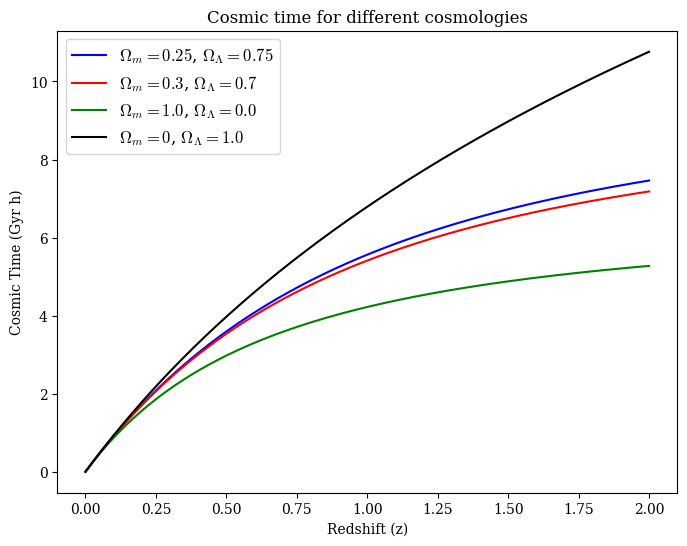

In [ ]:
H0_s = H0 / (3.086e19)  # Convert H0 to 1/s
n = 400
z = np.linspace(0, 2, n)

colors = ['blue', 'red', 'green','black']


param_sets =[
    {"label": r"$\Omega_m=0.25$, $\Omega_\Lambda=0.75$", "omega_m": 0.25, "omega_lam": 0.75},
    {"label": r"$\Omega_m=0.3$, $\Omega_\Lambda=0.7$", "omega_m": 0.3, "omega_lam": 0.7},
    {"label": r"$\Omega_m=1.0$, $\Omega_\Lambda=0.0$", "omega_m": 1.0, "omega_lam": 0.0},
    {"label": r"$\Omega_m=0$, $\Omega_\Lambda=1.0$", "omega_m": 0, "omega_lam": 1}
]

fig, ax = plt.subplots(figsize=(8, 6))


for idx, params in enumerate(param_sets):
    omega_m = params["omega_m"]
    omega_lam = params["omega_lam"]
    label = params["label"]

    # Definir H(z) dentro del bucle
    def H(z):
        return np.sqrt(omega_m * (1 + z)**3 + omega_lam)

    time = np.zeros(n)

    for i in range(n):
        time[i] = (1 / H0_s) * si.quad(lambda z_: 1 / ((1 + z_) * H(z_)), 0, z[i])[0]

    time_Gyr = time / (3.15e16)

    plt.plot(z, time_Gyr, color=colors[idx], label=label)

plt.title("Cosmic time for different cosmologies")
plt.xlabel("Redshift (z)")
plt.ylabel("Cosmic Time (Gyr h)")
plt.legend(fontsize=12)



plt.show()

### Absolute magnitude without and with the evolution correction

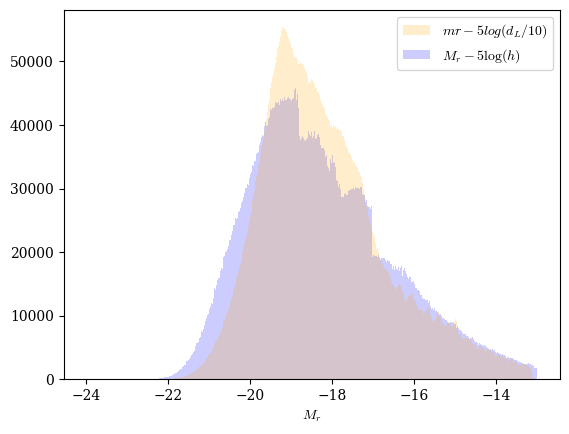

In [ ]:
abs_asah=data["des_asahi_full_r_true"]-5*np.log10(((1+data["z_cgal"])*data["cgal"]*10**6)/10)


bins = np.linspace(-24, -13, 500)

plt.hist(abs_asah, bins=bins, color='orange', alpha=0.2, label=r'$mr-5log(d_L/10)$',zorder=2)

plt.hist(data["mr_gal"], bins=bins, color='blue', alpha=0.2, label=r'$M_r-5\log(h)$',zorder=1)
plt.xlabel(r'$M_r$')

plt.legend()
plt.show()

### Evolution of magnitude through redshift(time)

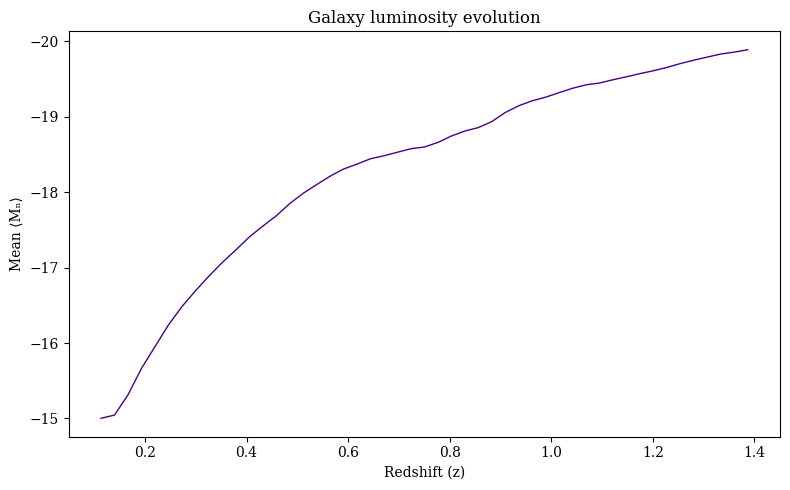

In [14]:
import numpy as np
import matplotlib.pyplot as plt

box = np.linspace(0.1, 1.4, 50)
averages = []
x_c = []

for i in range(1, len(box)):
    z_min, z_max = box[i-1], box[i]
    x = (z_min + z_max) / 2

    z_f = data[(data['z_cgal'] >= z_min) & (data['z_cgal'] < z_max)]
    mr_vals = z_f['mr_gal'].dropna()

    if len(mr_vals) > 0:
        avg_mag = mr_vals.mean()
        averages.append(avg_mag)
        x_c.append(x)
plt.figure(figsize=(8, 5))
plt.plot(x_c, averages, color='indigo', markersize=4, linewidth=1)
plt.xlabel('Redshift (z)')
plt.ylabel('Mean ⟨Mₙ⟩')
plt.title('Galaxy luminosity evolution')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()








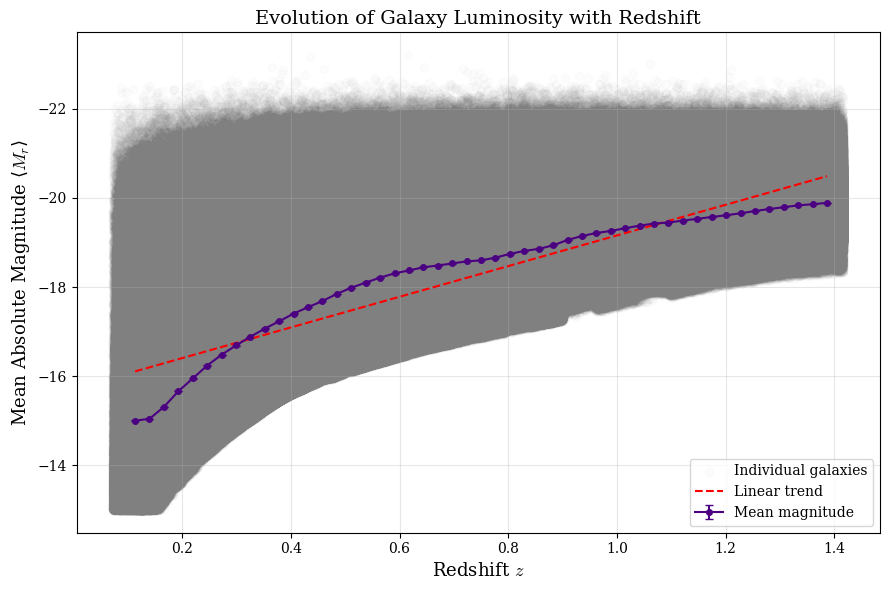

In [13]:
import numpy as np
import matplotlib.pyplot as plt


box = np.linspace(0.1, 1.4, 50)
averages = []
errors = []
x_c = []

# Loop through redshift bins
for i in range(1, len(box)):
    z_min, z_max = box[i-1], box[i]
    x = (z_min + z_max) / 2

    # Select galaxies in the bin
    z_f = data[(data['z_cgal'] >= z_min) & (data['z_cgal'] < z_max)]
    mr_vals = z_f['mr_gal'].dropna()

    
    if len(mr_vals) > 0:
        avg_mag = mr_vals.mean()
        std_error = mr_vals.std() / np.sqrt(len(mr_vals))
        averages.append(avg_mag)
        errors.append(std_error)
        x_c.append(x)


plt.figure(figsize=(9, 6))


plt.scatter(data['z_cgal'], data['mr_gal'], alpha=0.02, color='gray', label='Individual galaxies')

# Error bars for mean magnitudes
plt.errorbar(x_c, averages, yerr=errors, fmt='o-', color='indigo',
             markersize=4, linewidth=1.5, capsize=3, label='Mean magnitude')

# Linear fit/trend
coeffs = np.polyfit(x_c, averages, 1)
trend = np.poly1d(coeffs)
plt.plot(x_c, trend(x_c), 'r--', label='Linear trend')


plt.xlabel('Redshift $z$', fontsize=13)
plt.ylabel('Mean Absolute Magnitude ⟨$M_r$⟩', fontsize=13)
plt.title('Evolution of Galaxy Luminosity with Redshift', fontsize=14)
plt.gca().invert_yaxis()  # Brighter = more negative
plt.grid(True, alpha=0.3)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Galaxy Color 

We estimate the galaxy color distribution as a function of luminosity (magnitude) and fit the color histograms with Gaussian curves based on parameters from previous studies.

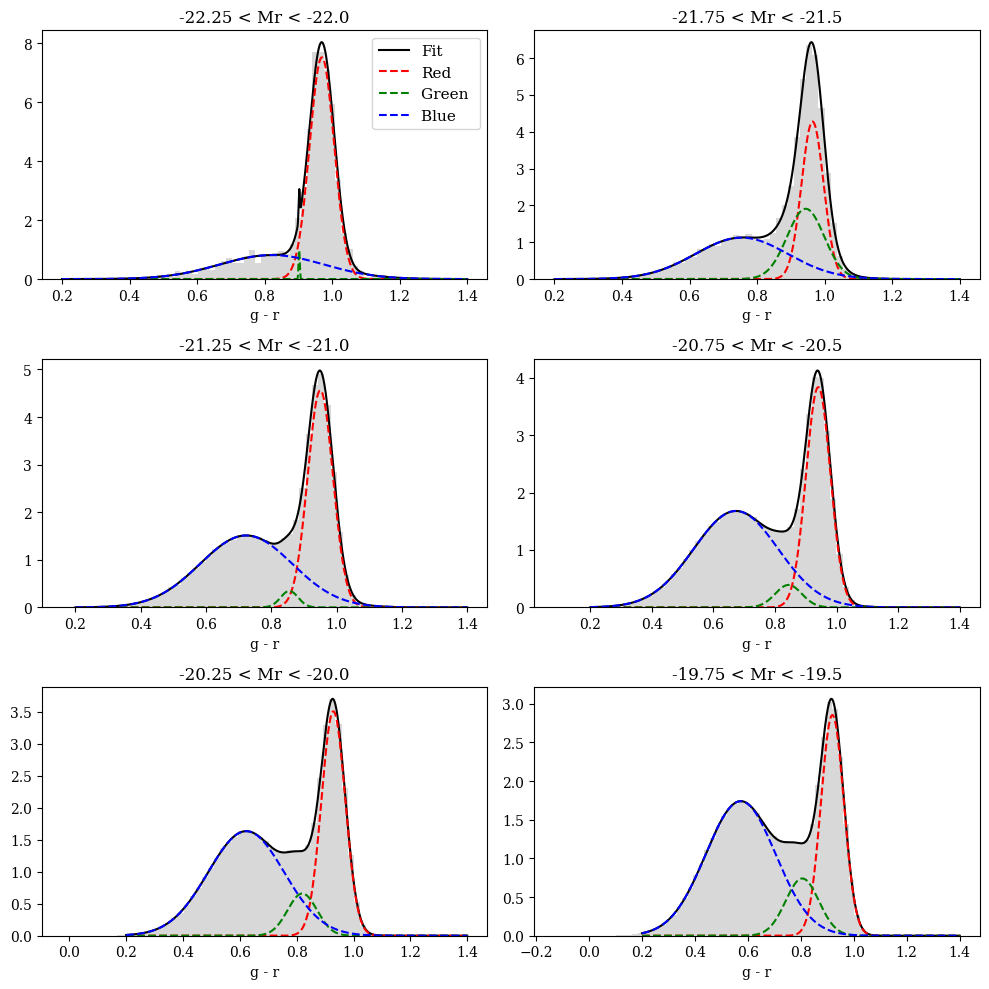

In [15]:


import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def gauss(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def triple_gauss(x, A_r, mu_r, sigma_r, A_b, mu_b, sigma_b, A_g, mu_g, sigma_g):
    return (gauss(x, A_r, mu_r, sigma_r) +
            gauss(x, A_b, mu_b, sigma_b) +
            gauss(x, A_g, mu_g, sigma_g))

def get_initial_params(Mr):
    A_r = A_b = A_g = 1.0

    mu_r = 0.923 - 0.021 * (Mr + 20)
    sigma_r = 0.041 - 0.003 * (Mr + 20)

    if Mr >= -22:
        mu_b = 0.61 - 0.1 * (Mr + 20)
    else:
        mu_b = 0.81 - 0.02 * (Mr + 22)
    sigma_b = 0.17 - 0.005 * (Mr + 20) - 0.037 * np.tanh((Mr + 22.38)/0.27)

    #mu_g = 0.88 - 0.035 * (Mr + 20) - 0.062 * np.tanh((Mr + 22.6)/0.12)
    if -22.0 >= Mr >= -22.5:
        mu_g = 0.90
        sigma_g = 0.055 + 0.023 * (Mr + 20)
    elif -21.25 < Mr < -21.0:
        mu_g = 0.82 #0.88 - 0.035 * (Mr + 20) - 0.062 * np.tanh((Mr + 22.6)/0.12)
        sigma_g = 0.068 - 0.020 * (Mr + 22.75)
    elif -22.75 <= Mr < -22.5:
        mu_g = 0.88 - 0.035 * (Mr + 20) - 0.062 * np.tanh((Mr + 22.6)/0.12)
        sigma_g = -0.002 - 0.280 * (Mr + 22.5)
    else:
        mu_g = 0.88 - 0.035 * (Mr + 20) - 0.062 * np.tanh((Mr + 22.6)/0.12)
        sigma_g = 0.068 - 0.020 * (Mr + 22.75)

    sigma_g *= 0.6

    return [A_r, mu_r, sigma_r, A_b, mu_b, sigma_b, A_g, mu_g, sigma_g]


bins = [(-22.25, -22.00), (-21.75, -21.50), (-21.25, -21.00),
        (-20.75, -20.50), (-20.25, -20.00), (-19.75, -19.50)]

fig, axes = plt.subplots(3, 2, figsize=(10, 10))
axes = axes.flatten()

for i, (Mr_min, Mr_max) in enumerate(bins):
    Mr_mid = (Mr_min + Mr_max) / 2
    ax = axes[i]

    mask = (data['mr_gal'] > Mr_min) & (data['mr_gal'] <= Mr_max)
    colors = data[mask]['gr_gal']

    y_hist, edges = np.histogram(colors,bins=60, density=True)
    x_hist = (edges[:-1] + edges[1:]) / 2

    popt, _ = curve_fit(triple_gauss, x_hist, y_hist,p0=get_initial_params(Mr_mid),bounds=(0, np.inf),maxfev=20000)

    x_fit = np.linspace(0.2, 1.4, 1000)
    y_total = triple_gauss(x_fit, *popt)
    y_r = gauss(x_fit, *popt[0:3])
    y_b = gauss(x_fit, *popt[3:6])
    y_g = gauss(x_fit, *popt[6:9])

    ax.hist(colors, bins=60,density=True, alpha=0.3, color='gray')
    ax.plot(x_fit, y_total, 'k-')
    ax.plot(x_fit, y_r, 'r--')
    ax.plot(x_fit, y_g, 'g--')
    ax.plot(x_fit, y_b, 'b--')
    ax.set_title(f"{Mr_min} < Mr < {Mr_max}")
    ax.set_xlabel("g - r")
    if i == 0:
      ax.legend(
        labels=['Fit', 'Red', 'Green ', 'Blue '],

        fontsize=11
      )

plt.tight_layout()


plt.show()

### Distribution of luminosity across time

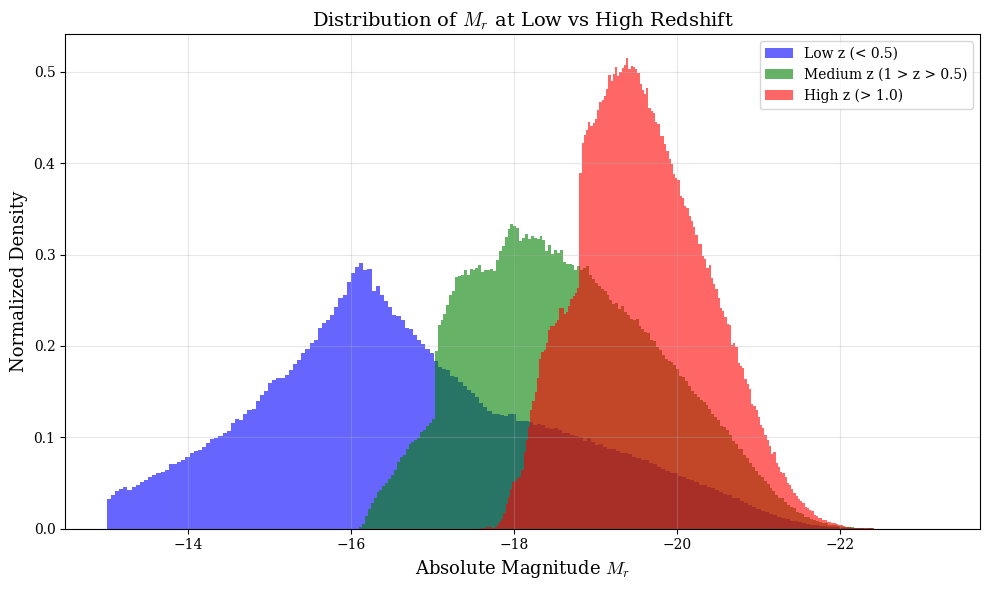

In [ ]:
import matplotlib.pyplot as plt

low_z = data[data['z_cgal'] < 0.5]['mr_gal'].dropna()
medium_z=data[(data['z_cgal'] > 0.5) & (data['z_cgal'] < 1)]['mr_gal'].dropna()
high_z = data[data['z_cgal'] > 1.0]['mr_gal'].dropna()


plt.figure(figsize=(10, 6))
plt.hist(low_z, bins=200, alpha=0.6, color='blue', label='Low z (< 0.5)', density=True)
plt.hist(medium_z, bins=200, alpha=0.6, color='green', label='Medium z (1 > z > 0.5)', density=True)
plt.hist(high_z, bins=200, alpha=0.6, color='red', label='High z (> 1.0)', density=True)


plt.xlabel('Absolute Magnitude $M_r$', fontsize=13)
plt.ylabel('Normalized Density', fontsize=13)
plt.title('Distribution of $M_r$ at Low vs High Redshift', fontsize=14)
plt.gca().invert_xaxis()
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

This notebook provides a visual and computational exploration of mock galaxy data, illustrating how galaxy properties and evolution can be studied using simulations like Euclid’s mock catalogues.